In [3]:
from collections import Counter

import numpy as np
import pandas as pd

import scipy.sparse as spr
import pickle

import import_ipynb
from util import write_json, load_json
from evaluate import CustomEvaluator
from ubcf_model import rec

importing Jupyter notebook from util.ipynb
importing Jupyter notebook from evaluate.ipynb
importing Jupyter notebook from ubcf_model.ipynb


# User-Based Collaborative Filtering
개념: 비슷한 특징을 가진 사람들은 비슷한 취향임을 가정한다.

In [4]:
# train_data, validation_data 준비!
from load_data import carol_data
from load_data import train_playlist
from load_data import val_playlist

importing Jupyter notebook from load_data.ipynb
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_baske

NameError: name 'song_id_sid' is not defined

### training 전에 데이터를 준비해보자!

In [5]:
train_playlist['istrain'] = 1 # 원본 데이터를 훼손하지 않기 위해서!
val_playlist['istrain'] = 0

n_train = len(train_playlist)
n_val = len(val_playlist)

# train + val
plylist = pd.concat([train_playlist, val_playlist], ignore_index=True) # 데이터 전처리를 한 번에 하기 위해

# playlist id
plylist["nid"] = range(n_train + n_val) # tain_data id 새로 생성 (load_data에서 확인해본 결과 0 - 115070가 아니여서)

# id <-> nid
plylist_id_nid = dict(zip(plylist["id"],plylist["nid"]))  # id를 가지고 nid를 구하자!
plylist_nid_id = dict(zip(plylist["nid"],plylist["id"])) # nid를 가지고 id를 구하자!

In [6]:
plylist_song = plylist['songs']
song_counter = Counter([sg for sgs in plylist_song for sg in sgs])
song_dict = {x: song_counter[x] for x in song_counter}

song_id_sid = dict()
song_sid_id = dict()
for i, t in enumerate(song_dict):
  song_id_sid[t] = i
  song_sid_id[i] = t

n_songs = len(song_dict)

In [8]:
plylist['songs_id'] = plylist['songs'].map(lambda x: [song_id_sid.get(s) for s in x if song_id_sid.get(s) != None])

In [11]:
plylist_use=plylist[['istrain','nid','updt_date','songs_id']]
plylist_use.loc[:,'num_songs'] = plylist_use['songs_id'].map(len) # num_songs의 열을 만들어서 플리에 들어있는 song의 수 저장
plylist_use =plylist_use.set_index('nid') # nid를 id로 사용!

C:\anaconda\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [12]:
plylist_train = plylist_use.iloc[:n_train,:]
plylist_test = plylist_use.iloc[n_train:,:]

In [17]:
# sample val (300개만 뽑아서)
np.random.seed(33)
n_sample = 200

test = plylist_test.iloc[np.random.choice(range(n_val), n_sample, replace=False),:]

In [18]:
# row가 playlist(nid)이고 column이 item(sid)인 sparse matrix A를 만들자!

row = np.repeat(range(n_train), plylist_train['num_songs'])
col = [song for songs in plylist_train['songs_id'] for song in songs]
dat = np.repeat(1, plylist_train['num_songs'].sum())
train_songs_A = spr.csr_matrix((dat, (row, col)), shape=(n_train, n_songs))

In [19]:
# row가 playlist(nid)이고 column이 item(sid or tid)인 sparse matrix A를 만듭니다.
row = np.repeat(range(n_train), plylist_train['num_songs'])
col = [song for songs in plylist_train['songs_id'] for song in songs]
dat = np.repeat(1, plylist_train['num_songs'].sum())
train_songs_A = spr.csr_matrix((dat, (row, col)), shape=(n_train, n_songs))

In [20]:
train_songs_A_T = train_songs_A.T.tocsr()

In [35]:
train_data=pd.DataFrame(train_songs_A.toarray())
train_data

,0,1,2,3,4,5,6,7,8,9,...,12925,12926,12927,12928,12929,12930,12931,12932,12933,12934
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
for a in train_data['0']:
    print(a)

NameError: name 'train_data' is not defined

In [39]:
# user similarity on replacing NAN by item(movie) avg
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
cosine = cosine_similarity(train_data) #코사인 유사도 사용

np.fill_diagonal(cosine, 0 )

similarity_with_plylst =pd.DataFrame(cosine,index=train_data.index) #playlist간의 유사성을 계산한다.

similarity_with_plylst.columns=train_data.index

similarity_with_plylst.head()

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.045622,0.058476,0.051571,0.055132,0.000000,0.009577,...,0.015376,0.024311,0.000000,0.019850,0.157903,0.0,0.049548,0.0,0.014697,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.022917,0.000000,0.000000,...,0.025565,0.040423,0.000000,0.000000,0.000000,0.0,0.027462,0.0,0.036656,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.042192,0.000000,...,0.000000,0.045572,0.000000,0.000000,0.009867,0.0,0.015480,0.0,0.247958,0.0
4,0.0,0.045622,0.0,0.0,0.000000,0.153252,0.073721,0.098514,0.032174,0.000000,...,0.054948,0.052129,0.027864,0.141876,0.120386,0.0,0.070829,0.0,0.015757,0.0


### Training을 해보자!

K값을 30으로 설정하였다.

find_n_neighbours: 유사도 행렬과 n의 값을 입력으로 받고 모든 플레이리스트에 대해 가장 가까운 n이웃을 반환단다.

In [40]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [48]:
# top 30 neighbours for each user
sim_user_30_m = find_n_neighbours(similarity_with_plylst,30)
sim_user_30_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top21,top22,top23,top24,top25,top26,top27,top28,top29,top30
0,456,154,183,539,965,702,844,684,685,692,...,693,679,695,696,697,698,699,700,701,703
1,567,203,209,743,132,1024,699,901,523,805,...,923,952,680,138,541,953,691,243,336,909
2,152,44,783,745,776,413,982,240,895,198,...,222,508,61,668,718,497,90,427,671,376
3,1028,115,473,292,1006,974,450,40,787,432,...,103,970,855,55,866,371,602,68,761,147
4,842,319,33,567,173,849,209,89,697,864,...,5,909,72,295,674,1023,302,601,282,353


In [51]:
def User_item_score(user,item,sim_user_30_m):
    a = sim_user_30_m[sim_user_30_m.index==user].values
    b = a.squeeze().tolist()
    c = train_data.loc[:,item]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    avg_user = Mean.loc[Mean['userId'] == user,'rating'].values[0]
    index = f.index.values.squeeze().tolist()
    corr = similarity_with_plylst.loc[user,index]
    fin = pd.concat([f, corr], axis=1)
    fin.columns = ['adg_score','correlation']
    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()
    deno = fin['correlation'].sum()
    final_score = avg_user + (nume/deno)
    return final_score

In [52]:
core = User_item_score(320,7371,sim_user_30_m)
print("score (u,i) is",score)

NameError: name 'Mean' is not defined

# Score function
song에 대한 playlist의 선호도

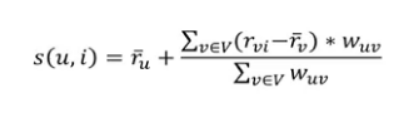

s: 예측한 Score값
u: 사용자(플레이리스트)
i: 아이템(song)
r: 사용자의 플레이리스트에 있는 song의 유무
w: 가중치

따라서 점수는 각 사용자의 song에 대해 평균평점을 빼고 가중치를 곱한것의 합이다.
이때 가중치는 사용자가 다른사용자의 예측에 얼마나 기여할 것인지에 대한 가중치로 사용자 u와v사이의 가중치이다.
가중치 계산을 위해 코사인 유사도를 사용하였고 neighber를 사용하였다.
sklearn의 cosine_similarity를 사용하였다.

In [ ]:
Ratings = pd.read_csv("ratings.csv")

In [ ]:
Mean = Ratings.groupby(by="userId",as_index=False)['rating'].mean()
Rating_avg = pd.merge(Ratings,Mean,on='userId')
Rating_avg['adg_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
Rating_avg.head()

In [ ]:
Rating_avg = Rating_avg.astype({"movieId": str})
Movie_user = Rating_avg.groupby(by = 'userId')['movieId'].apply(lambda x:','.join(x))

In [ ]:
def User_item_score1(user):
    Movie_seen_by_user = check.columns[check[check.index==user].notna().any()].tolist()
    a = sim_user_30_m[sim_user_30_m.index==user].values
    b = a.squeeze().tolist()
    d = Movie_user[Movie_user.index.isin(b)]
    l = ','.join(d.values)
    Movie_seen_by_similar_users = l.split(',')
    Movies_under_consideration = list(set(Movie_seen_by_similar_users)-set(list(map(str, Movie_seen_by_user))))
    Movies_under_consideration = list(map(int, Movies_under_consideration))
    score = []
    for item in Movies_under_consideration:
        c = final_movie.loc[:,item]
        d = c[c.index.isin(b)]
        f = d[d.notnull()]
        avg_user = Mean.loc[Mean['userId'] == user,'rating'].values[0]
        index = f.index.values.squeeze().tolist()
        corr = similarity_with_movie.loc[user,index]
        fin = pd.concat([f, corr], axis=1)
        fin.columns = ['adg_score','correlation']
        fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
        nume = fin['score'].sum()
        deno = fin['correlation'].sum()
        final_score = avg_user + (nume/deno)
        score.append(final_score)
    data = pd.DataFrame({'movieId':Movies_under_consideration,'score':score})
    top_5_recommendation = data.sort_values(by='score',ascending=False).head(5)
    Movie_Name = top_5_recommendation.merge(movies, how='inner', on='movieId')
    Movie_Names = Movie_Name.title.values.tolist()
    return Movie_Names

In [ ]:
user = int(input("Enter the user id to whom you want to recommend : "))
predicted_movies = User_item_score1(user)
print(" ")
print("The Recommendations for User Id : 370")
print("   ")
for i in predicted_movies:
    print(i)

In [ ]:
answers = rec(test.index)

In [ ]:
write_json(answers, "results/results.json") # 예측값 저장!

### 모델 평가를 해보자!

In [ ]:
evaluator = CustomEvaluator()
evaluator.evaluate("data/val.json", "data/results/results.json")